In [19]:
% matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import us

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

#  Download data

### Counties have internet

Randomly sample 10,000 samples in order to handle large data set

In [2]:
query = """
WITH county_geo AS (
  SELECT  
    census_block.state_county_code, 
    AVG(census_block.land_area) AS area
  FROM broadband.census_block census_block
  GROUP BY census_block.state_county_code
),
no_internet_block AS (
  SELECT 
    block.state_county_code,
    CASE WHEN fcc.max_down IS NULL THEN 1 ELSE 0 END AS count_no_internet
  FROM broadband.census_block block
  LEFT JOIN broadband.fcc fcc
      ON block.block_code = fcc.block_code
),
full_internet_county AS (
  SELECT state_county_code
  FROM no_internet_block
  GROUP BY state_county_code
  HAVING SUM(count_no_internet) = 0
)

SELECT
  full_internet_county.state_county_code, 
  income.census_income_2016 AS income,
  housing.total_housing_units2010census / county_geo.area AS housing_density,
  population.census_population_2010 / county_geo.area AS population_density,
  education.bachelor_or_higher
FROM full_internet_county
LEFT JOIN county_geo
  ON full_internet_county.state_county_code = county_geo.state_county_code
LEFT JOIN broadband.census_income income
  ON full_internet_county.state_county_code = income.state_county_code
LEFT JOIN broadband.census_housing housing
  ON full_internet_county.state_county_code = housing.state_county_code
LEFT JOIN broadband.census_population population
  ON full_internet_county.state_county_code = population.state_county_code
LEFT JOIN broadband.census_education education
  ON full_internet_county.state_county_code = education.state_county_code
"""
internet = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [3]:
# convert to sq miles
internet.housing_density = internet.housing_density *2.59*10**6
internet.population_density = internet.population_density *2.59*10**6

In [4]:
attrs = ['income',
         'housing_density',
         'population_density',
         'bachelor_or_higher']
internet[attrs] = internet[attrs].astype(np.float)

### Counties do not have internet

In [5]:
query = """
WITH county_geo AS (
SELECT  
  census_block.state_county_code, 
  AVG(census_block.land_area) AS area
FROM broadband.census_block census_block
GROUP BY census_block.state_county_code
)

SELECT
  block.latitude,
  block.longitude,
  block.state_county_code, 
  block.state_abbr,
  block.state,
  block.county,
  income.census_income_2016 AS income,
  housing.total_housing_units2010census / county_geo.area AS housing_density,
  population.census_population_2010 / county_geo.area AS population_density,
  education.bachelor_or_higher
FROM broadband.census_block block
LEFT JOIN broadband.fcc fcc
    ON block.block_code = fcc.block_code
LEFT JOIN county_geo
  ON county_geo.state_county_code = block.state_county_code
LEFT JOIN broadband.census_income income
  ON block.state_county_code = income.state_county_code
LEFT JOIN broadband.census_housing housing
  ON block.state_county_code = housing.state_county_code
LEFT JOIN broadband.census_population population
  ON block.state_county_code = population.state_county_code
LEFT JOIN broadband.census_education education
  ON block.state_county_code = education.state_county_code
WHERE 
  fcc.max_down IS NULL AND 
  (block.land_area - block.water_area) > 0
"""
no_internet = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [6]:
no_internet[attrs] = no_internet[attrs].astype(np.float)

In [7]:
# convert to sq miles
no_internet.housing_density = no_internet.housing_density *2.59*10**6
no_internet.population_density = no_internet.population_density *2.59*10**6

In [8]:
no_internet_blocks = no_internet.copy()
no_internet = no_internet_blocks.drop_duplicates('state_county_code')

In [9]:
no_internet.count()

latitude              2527
longitude             2527
state_county_code     2527
state_abbr            2527
state                 2527
county                2527
income                2504
housing_density       2527
population_density    2525
bachelor_or_higher    2525
dtype: int64

# Which state has 100% broadband access?

In [10]:
exc = ['HI', 'AK']
no_internet_states = no_internet.state_abbr.unique()

for s in us.STATES:
    if s.abbr not in exc:
        if s.abbr not in no_internet_states:
            print(s)

Wyoming


# Comparing the counties with and without internet in terms of 

1. income
2. housing density
3. population density
4. percent of population who holds bachelor or higher degree

In [11]:
def plot_by_attr(attr):
    df = pd.concat([
        pd.DataFrame({attr: internet[attr], 'internet': 'yes'}),
        pd.DataFrame({attr: no_internet[attr], 'internet': 'no'})
    ])

    ax = df.boxplot(by='internet', return_type='axes', figsize=(8, 6))
    plt.title(attr.title(), fontsize=16)
    plt.suptitle('')
    plt.xlabel('Internet Avaiability', fontsize=16)
    plt.ylabel(attr.title(), fontsize=16)
    plt.show()
    
    print(df.groupby('internet')[attr].describe().T)

### Income

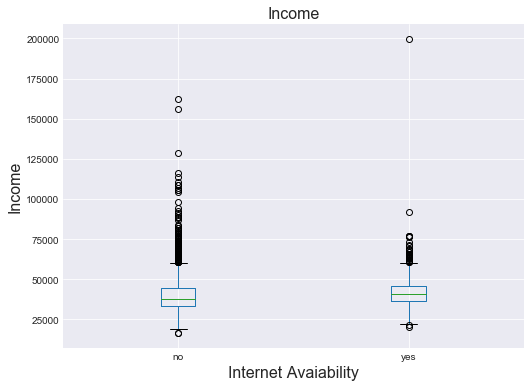

internet         no        yes
count      2,504.00     548.00
mean      40,202.24  42,377.61
std       11,151.31  11,398.10
min       16,267.00  20,353.00
25%       33,411.25  36,384.25
50%       37,871.50  41,049.50
75%       44,301.50  45,996.00
max      162,378.00 199,635.00


In [12]:
plot_by_attr('income')

Median income of the county without internet is \$37,871 and with \$41,049

Number of counties whose mean income is above 50000

In [13]:
no_internet[no_internet.income > 50000].shape[0]

308

Top 5 counties at lest one of their census blocks do not get internet

In [14]:
no_internet.sort_values('income', ascending=False).head()

,latitude,longitude,state_county_code,state_abbr,state,county,income,housing_density,population_density,bachelor_or_higher
681702,32.57,-99.10,48417,TX,Texas,Shackelford County,"162,378.00","2,361.61","4,548.18",25.20
538175,40.69,-74.02,36061,NY,New York,New York County,"156,048.00","147,683,720.15","276,484,935.87",60.40
135228,39.32,-106.65,08097,CO,Colorado,Pitkin County,"128,738.00","15,532.44","20,562.83",60.40
83509,38.15,-122.71,06041,CA,California,Marin County,"115,952.00","962,870.76","2,185,311.61",57.10
1228892,41.98,-98.39,31183,NE,Nebraska,Wheeler County,"113,939.00",246.35,349.85,16.60


### Housing density

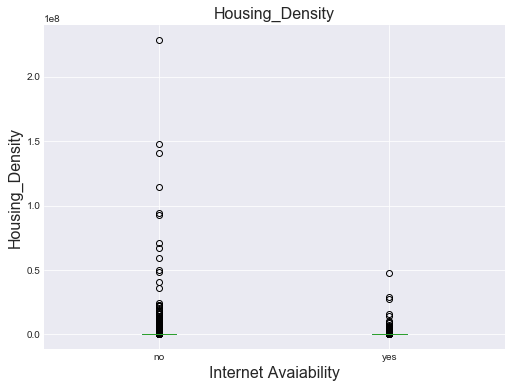

internet             no           yes
count          2,527.00        555.00
mean         976,157.47    554,440.91
std        7,787,810.91  2,944,312.87
min               58.01        248.73
25%           15,199.99     10,720.19
50%           46,609.78     39,761.48
75%          177,171.83    130,472.32
max      228,527,716.52 47,715,350.61


In [15]:
plot_by_attr('housing_density')

Large difference between these groups

In [16]:
no_internet.sort_values('housing_density', ascending=False).head()

,latitude,longitude,state_county_code,state_abbr,state,county,income,housing_density,population_density,bachelor_or_higher
936894,41.81,-87.68,17031,IL,Illinois,Cook County,"56,669.00","228,527,716.52","544,464,106.97",36.50
538175,40.69,-74.02,36061,NY,New York,New York County,"156,048.00","147,683,720.15","276,484,935.87",60.40
538687,40.62,-74.04,36047,NY,New York,Kings County,"44,502.00","140,791,356.70","352,536,817.84",34.10
538186,40.76,-73.85,36081,NY,New York,Queens County,"43,467.00","114,063,469.42","304,676,882.22",30.60
610886,39.99,-75.09,42101,PA,Pennsylvania,Philadelphia County,"51,645.00","94,212,649.89","214,525,947.87",26.40


# Population density

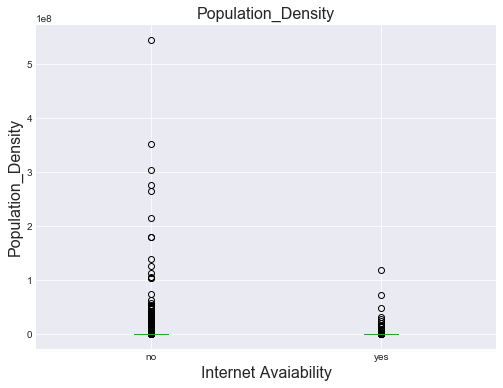

internet             no            yes
count          2,525.00         555.00
mean       2,597,940.69   1,285,132.02
std       19,096,257.65   6,952,633.92
min               95.14         465.11
25%           30,255.82      22,485.43
50%           98,809.81      86,516.10
75%          393,084.76     304,918.49
max      544,464,106.97 119,794,056.85


In [17]:
plot_by_attr('population_density')

In [20]:
no_internet.sort_values('population_density', ascending=False).head()

,latitude,longitude,state_county_code,state_abbr,state,county,income,housing_density,population_density,bachelor_or_higher
936894,41.805196,-87.684075,17031,IL,Illinois,Cook County,"56,669.000000","228,527,716.518280","544,464,106.967979",36.500000
538687,40.619756,-74.041268,36047,NY,New York,Kings County,"44,502.000000","140,791,356.699128","352,536,817.836680",34.100000
538186,40.758217,-73.852654,36081,NY,New York,Queens County,"43,467.000000","114,063,469.415372","304,676,882.224137",30.600000
538175,40.688033,-74.023375,36061,NY,New York,New York County,"156,048.000000","147,683,720.151796","276,484,935.872562",60.400000
83469,33.932028,-118.388141,06037,CA,California,Los Angeles County,"55,624.000000","93,028,299.383864","265,134,390.495857",30.800000


### Percent of population who holds bachelor or higher degree

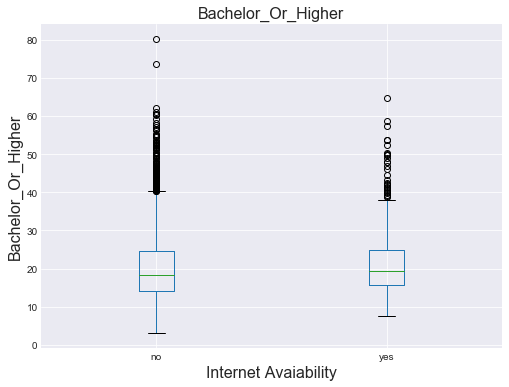

internet           no        yes
count    2,525.000000 555.000000
mean        20.652000  21.294414
std          9.266050   8.559471
min          3.000000   7.500000
25%         14.100000  15.800000
50%         18.300000  19.400000
75%         24.600000  24.800000
max         80.200000  64.600000


In [22]:
plot_by_attr('bachelor_or_higher')